In [17]:
import tensorflow as tf
import tensorflow.contrib as tc
import tensorflow.contrib.layers as tcl
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import matplotlib.gridspec as gridspec
import os

In [18]:
def leaky_relu(x, th=0.2):
    return tf.maximum(tf.minimum(0.0, th * x), x)    
    
def batch_sampler(x):    
    shuff_idx = np.arange(x.shape[0])
    np.random.shuffle(shuff_idx)
    return x[shuff_idx]
                
class MLP_WGAN(object):
    def __init__(self, train_data, mb_size, train_epoch, x_dim, z_dim, n_fig, out_dir, color, penalty=10, n_disc=5):
        self.train_data = train_data
        self.mb_size = mb_size            ## size of the mini-batch
        self.train_epoch = train_epoch    ## number of training epochs
        self.x_dim = x_dim                ## the dimensionality of the input images
        self.z_dim = z_dim                ## size of the initial noise passed through the generator
        self.n_fig = n_fig                ## number of figures for each plot
        self.out_dir = out_dir            ## storing sampled images
        self.penalty = penalty            ## gradient penalty
        self.n_disc = n_disc              ## number of disciminator steps per generator step
        self.color = color                ## if the images are RGB or grey-scale
  
    def plot(self, samples):
        size = int(np.sqrt(self.n_fig))
        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            if samples.shape[3] == 3:
                sample = sample.reshape(self.x_dim, self.x_dim, self.color)
                plt.imshow(sample)
            else:
                sample = sample.reshape(self.x_dim, self.x_dim)
                plt.imshow(sample, cmap='Greys_r')
             
        return fig

    def generator(self, x, isTrain=True):
        with tf.variable_scope('generator'):

            fc = x
            fc = tcl.fully_connected(
                fc, 512*self.color,
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                weights_regularizer=tc.layers.l2_regularizer(2.5e-5),
                activation_fn=tcl.batch_norm
            )
            fc = leaky_relu(fc)
            fc = tcl.fully_connected(
                fc, 512*self.color,
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                weights_regularizer=tc.layers.l2_regularizer(2.5e-5),
                activation_fn=tcl.batch_norm
            )
            fc = leaky_relu(fc)
            fc = tcl.fully_connected(
                fc, 512*self.color,
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                weights_regularizer=tc.layers.l2_regularizer(2.5e-5),
                activation_fn=tcl.batch_norm
            )
            fc = leaky_relu(fc)
            fc = tc.layers.fully_connected(
                fc, self.x_dim*self.x_dim*self.color,
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                weights_regularizer=tc.layers.l2_regularizer(2.5e-5),
                activation_fn=tf.sigmoid
            )

            fc = tf.reshape(fc, [tf.shape(x)[0], self.x_dim, self.x_dim, self.color])
            return fc

    def discriminator(self, x, isTrain=True, reuse=True):
        with tf.variable_scope('discriminator', reuse=reuse):
            
            conv1 = tc.layers.convolution2d(
                x, 64, [4, 4], [2, 2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=tf.identity
            )
            conv1 = leaky_relu(conv1)
            conv2 = tc.layers.convolution2d(
                conv1, 128, [4, 4], [2, 2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=tf.identity
            )
            conv2 = leaky_relu(tc.layers.batch_norm(conv2))
            conv2 = tcl.flatten(conv2)
            fc1 = tc.layers.fully_connected(
                conv2, 1024,
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=tf.identity
            )
            fc1 = leaky_relu(tc.layers.batch_norm(fc1))
            fc2 = tc.layers.fully_connected(fc1, 1, activation_fn=tf.identity)
            return fc2
        
        
    def training(self):
        tf.reset_default_graph()

        with tf.name_scope('inputs'):
            X = tf.placeholder(tf.float32, shape=(None, self.x_dim, self.x_dim, self.color)) ## dataset
            z = tf.placeholder(tf.float32, shape=(None, self.z_dim)) ## noise passed to generator

        G_sample = self.generator(z)
        print(G_sample.shape)
        D_real = self.discriminator(X, reuse=False)
        D_fake = self.discriminator(G_sample)

        D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
        G_loss = tf.reduce_mean(D_fake)
        
        alpha = tf.random_uniform([], minval=0.,maxval=1.)
        x_hat = X*alpha + (1-alpha)*G_sample
        gradients = tf.gradients(self.discriminator(x_hat), [x_hat])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1))
        gradient_penalty = self.penalty*tf.reduce_mean(tf.square(slopes - 1.0))
        D_loss += gradient_penalty


        T_vars = tf.trainable_variables()
        D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
        G_vars = [var for var in T_vars if var.name.startswith('generator')]

        G_solver = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5,
                                          beta2=0.9).minimize(G_loss, var_list=G_vars)


        D_solver = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, 
                                          beta2=0.9).minimize(D_loss, var_list=D_vars)

        if not os.path.exists(self.out_dir):
            os.makedirs(self.out_dir)
        
        
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())
        
        i = 0
        for epoch in range(0, self.train_epoch):
                
            for _ in range(0, self.n_disc):
                    
                batch_images = batch_sampler(self.train_data)[0:self.mb_size]
                batch_z = np.random.normal(-1.0, 1.0, size=[self.mb_size, self.z_dim]).astype(np.float32)

                _, D_loss_curr = sess.run([D_solver, D_loss],
                    feed_dict={X: batch_images, z: batch_z})
                    
            batch_z = np.random.normal(-1.0, 1.0, size=[self.mb_size, self.z_dim]).astype(np.float32)    
            _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={z: batch_z})

            if epoch % 100 == 0:
                print('Iter: {}; D loss: {:.4}; G_loss: {:.4}'.format(i, D_loss_curr, G_loss_curr))
                batch_z  = np.random.normal(-1.0, 1.0, size=[self.n_fig, self.z_dim]).astype(np.float32)
                samples = sess.run(G_sample, feed_dict={z: batch_z})
                fig = self.plot(samples)
                plt.savefig(out_dir + '/{}.png'
                            .format(str(i).zfill(3)), bbox_inches='tight')
                i += 1
                plt.close(fig)
                

In [19]:
mb_size = 64
z_dim = 100
n_fig= 16
out_dir = 'out_MLP_GAN_new'
n_disc = 5
train_epoch = 1000000
penalty = 10

In [20]:
# MNIST data: resize and normalization
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])
train_set = mnist.train.images
# train_set = tf.image.resize_images(mnist.train.images, [64, 64]).eval(session=sess)
# train_set = (train_set - 0.5) / 0.5  # normalization; range: -1 ~ 1

print(train_set.shape)
x_dim = train_set.shape[1]
color = train_set.shape[3]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 28, 28, 1)


In [21]:
mnist_train = MLP_WGAN(train_set, mb_size, train_epoch, x_dim, z_dim, n_fig, out_dir, color, penalty, n_disc)

In [ ]:
mnist_train.training()

(?, 28, 28, 1)
Iter: 0; D loss: 4.64; G_loss: -0.2113


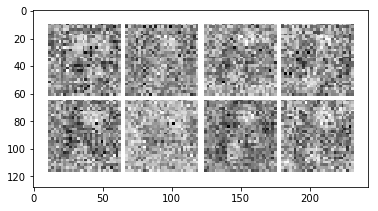

In [54]:
img=mpimg.imread('out_improved_DCGAN/004.png')
plt.imshow(img)